# Classification by Naive Bayes

![](banner_naive_bayes.jpg)

In [2]:
f = "setup.R"; for (i in 1:10) { if (file.exists(f)) break else f = paste0("../", f) }; source(f)
update_geom_defaults("point", list(size=3, colour=PALETTE[3]))

== document setup ==

## Introduction

Motivation, context, history, intuition, related topics ...

### Prosecutor's Fallacy

Certain DNA evidence is found at a crime scene.  At trial, the prosecutor knows that the probability of finding this DNA evidence, assuming the defendant is innocent, is only one in a million.  She claims therefore that the probability of the defendant being innocent given this DNA evidence is also only one in a million, but this is incorrect.  One in a million means that for every million people, the DNA evidence implicates just one of them.  But there are 7 billion people in the world - that is 7,000 times one million.  So, the DNA evidence implicates 7,000 people and the probability of the defendant being guilty is actually only one in 7,000.

This so called "prosecutor's fallacy" incorrectly treats the posterior conditional probability of A given B as equal to the conditional probability of B given A.  Really though, as described by Bayes Theorem, it depends on the prior unconditional probability of A and the prior unconditional probability of B, too.

The naive Bayes method constructs a classification model taking into account both conditional probabilities and prior probabilities implied by training data.

## Synopisis

**Terms**

* Prior
* Likelihood
  * Conditional probability (for categorical variables)
  * Conditional probability adjusted by LaPlace smoothing (for categorical variables)
  * Conditional probability density (for numeric variables)
* Posterior
  * Product of likelihoods and prior 
* Relative Posterior
  * Proportion of posterior 

## Exposition

### Naive Bayes & One Numeric Predictor Variable

#### Data

Consider this classified data. Each observation is known to be in either class A or class B.  

x1,class
1.0,A
8.0,A
8.5,A
9.5,A
11.0,A
9.0,B
14.0,B
15.0,B
16.0,B
16.5,B


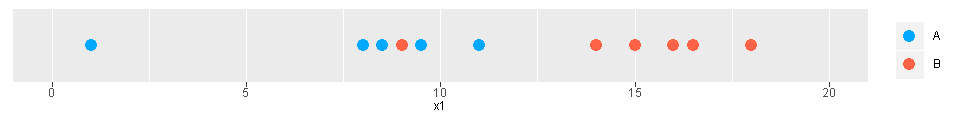

In [2]:
data = data.frame(x1=c(1,8,8.5,9.5,11,9,14,15,16,16.5,18), class=c("A", "A", "A", "A", "A", "B", "B", "B", "B", "B", "B"))
data %>% caption

output_size(8,1)
ggplot(data) + xlim(0,20) + geom_point(aes(x=x1, y=0, color=class)) + theme.x_axis_only
output_size(restore)

#### New Observation

Consider a new unclassified observation [ x1=10 ].

x1
10


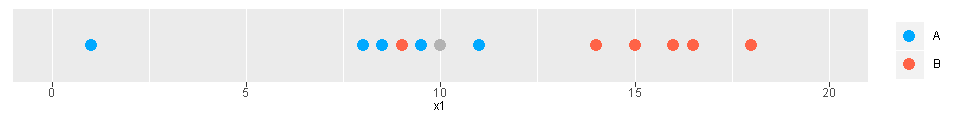

In [3]:
new = data.frame(x1=10)
new %>% caption

output_size(8,1)
ggplot(data) + xlim(0,20) +
geom_point(aes(x=x1, y=0, color=class)) + geom_point(aes(x=x1, y=0), data=new, color="grey70") +
theme.x_axis_only
output_size(restore)

#### Prediction by Likelihood

For any new unclassified observation, the probability density at that observation assuming it's of one class compared to the probability density at that observation assuming it's of another class is a reasonable basis for predicting the class of the new observation.  You can determine a probability density function for each class by kernel density estimation applied to the observations of that class.  In this context, we call the probability density the _likelihood_ that the observation is of a class.

Here we find a probability density function for the observations of class A and find another one for the observations of class B, based on kernel density estimation with Gaussian kernel and bandwidth 0.7.

In [4]:
data.A = data[data$class=="A",]
data.B = data[data$class=="B",]

row.arrange(data.A %>% captionx, data.B %>% captionx)

x1,class
1.0,A
8.0,A
8.5,A
9.5,A
11.0,A
x1,class
9.0,B
14.0,B
15.0,B
16.0,B


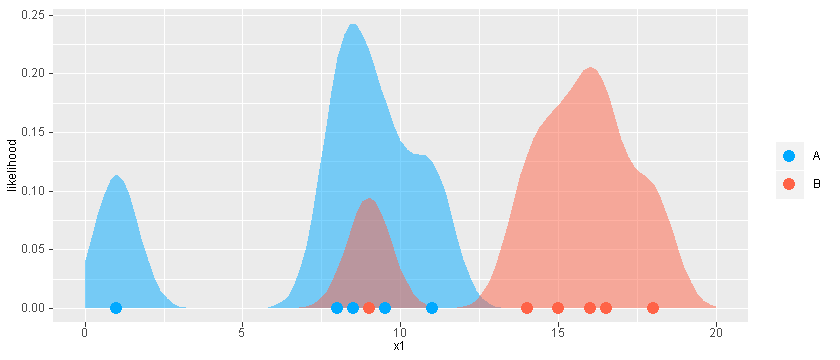

In [5]:
d.A = density(data.A$x1, bw=0.7, from=0, to=20); pdf.A = approxfun(d.A)
d.B = density(data.B$x1, bw=0.7, from=0, to=20); pdf.B = approxfun(d.B)

ggplot(data) + xlim(0,20) + ylab("likelihood") +
stat_function(fun=pdf.A, geom="area", fill=PALETTE[1], alpha=0.5) +
stat_function(fun=pdf.B, geom="area", fill=PALETTE[2], alpha=0.5) +
geom_point(aes(x=x1, y=0, color=class))

Then, the likelihood of the new observation [ x1=10 ] assuming that it's in class A is 0.14, and the likelihood of the new observation [ x1=10 ] assuming that it's in class B is 0.03.

x1,class,likelihood
10,A,0.14306430
10,B,0.03435121


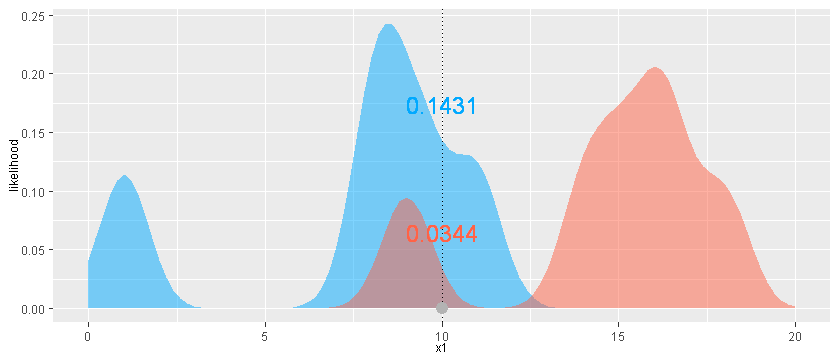

In [6]:
model.10 = data.frame(x1=10, class=c("A","B"), likelihood=c(pdf.A(10), pdf.B(10)))
model.10

ggplot(data) + xlim(0,20) + xlab("x1") + ylab("likelihood") +
stat_function(fun=pdf.A, geom="area", fill=PALETTE[1], alpha=0.5) +
stat_function(fun=pdf.B, geom="area", fill=PALETTE[2], alpha=0.5) +
geom_vline(aes(xintercept=10), lty="dotted") +
geom_point(aes(x=10, y=0), color="grey70") +
geom_text(aes(x=10, y=model.10[1,"likelihood"]), color=PALETTE[1], size=5, label=sprintf("%0.4f",model.10[1,"likelihood"])) +
geom_text(aes(x=10, y=model.10[2,"likelihood"]), color=PALETTE[2], size=5, label=sprintf("%0.4f",model.10[2,"likelihood"]))

Since 0.14 > 0.04, a reasonable prediction is that the new observation is in class A.

In [7]:
prediction = model.10$class[which.max(model.10$likelihood)]
data.frame(x1=10, class.predicted=prediction)

x1,class.predicted
10,A


#### Prediction by Prior

The probability of seeing any observation from one class compared to the probability of seeing any observation from another class is also a reasonable basis for predicting the class of the new observation.  You can determine the probability for each class as the number of observations of that class divided by the total number of observations.  In this context, we call the probability the _prior_ of the class.

Here the prior of class A is 0.45 and the prior of class B is 0.54.

In [8]:
row.arrange(data.A %>% captionx, data.B %>% captionx)

x1,class
1.0,A
8.0,A
8.5,A
9.5,A
11.0,A
x1,class
9.0,B
14.0,B
15.0,B
16.0,B


class,prior
A,0.4545455
B,0.5454545


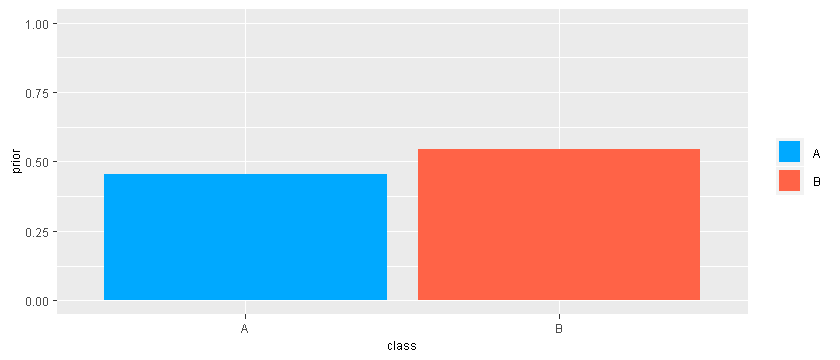

In [9]:
prior.A = nrow(data.A) / nrow(data)
prior.B = nrow(data.B) / nrow(data)

prob = data.frame(class=c("A","B"), prior=c(prior.A, prior.B))
prob

ggplot(prob) + ylim(0,1) +
geom_col(aes(x=class, y=prior, fill=class))

Since 0.45 < 0.54, a reasonable prediction is that the new observation is of class B.

In [10]:
prediction = prob$class[which.max(prob$prior)]
data.frame(x1=10, class.predicted=prediction)

x1,class.predicted
10,B


#### Prediction by Relative Posterior

For any new unclassified observation, a combination of its likehoods and priors is perhaps the best basis for predicting the class of the new observation.  In this context, we call the product of the likelihood and the prior the _posterior_ of the observation in a class.

Here the likelihood of observation [ x1=10 ] assuming that it's from class A is 0.143, the prior of class A is 0.454, and so the posterior for observation [ x1=10 ] in class A is 0.143 x 0.454 = 0.065.  Similarly, the posterior for observation [ x1=10 ] in class B is 0.034 x 0.545 = 0.018.

x1,class,likelihood,prior,posterior
10,A,0.14306430,0.4545455,0.06502923
10,B,0.03435121,0.5454545,0.01873702


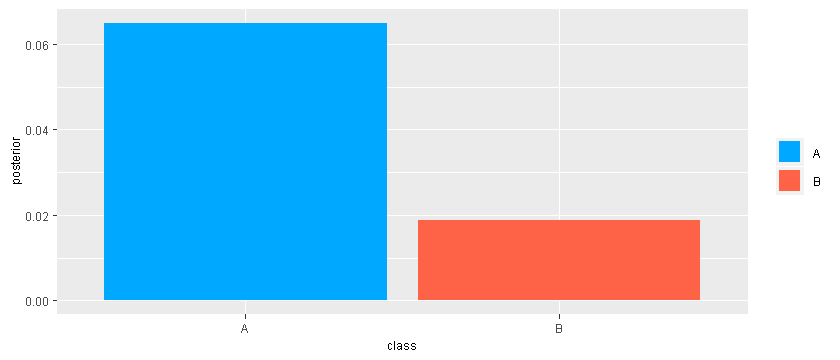

In [11]:
posterior.A = pdf.A(10) * prior.A
posterior.B = pdf.B(10) * prior.B

model.10 = data.frame(x1=10,
                      class=c("A","B"),
                      likelihood=c(pdf.A(10), pdf.B(10)),
                      prior=c(prior.A, prior.B),
                      posterior=c(posterior.A, posterior.B))

model.10
ggplot(model.10) + geom_col(aes(x=class, y=posterior, fill=class))

We call the ratio of one posterior to the sum of all posteriors the _relative posterior_.  We can treat a relative posterior as the probability that the new observation is of the corresponding class.

Here the relative posterior for observation [ x1=10 ] in class A is 0.065 / (0.065+0.018) = 0.776, and the relative posterior for observation [ x1=10 ] in class B is 0.018 / (0.065+0.018) = 0.223.

x1,class,likelihood,prior,posterior,relative_posterior,probability
10,A,0.14306430,0.4545455,0.06502923,0.7763177,0.7763177
10,B,0.03435121,0.5454545,0.01873702,0.2236823,0.2236823


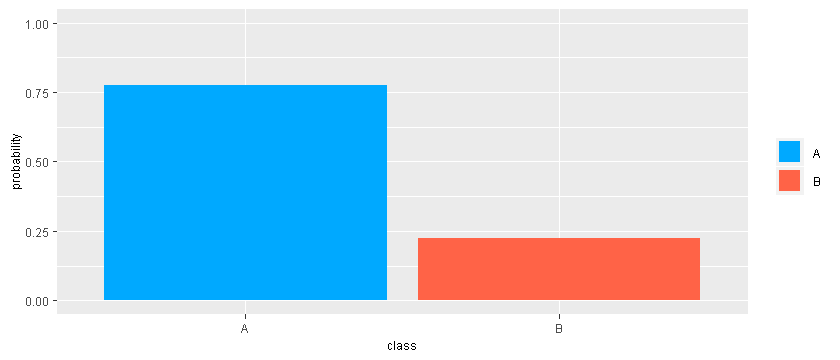

In [12]:
model.10 = data.frame(x1=10,
                      class=c("A","B"),
                      likelihood=c(pdf.A(10), pdf.B(10)),
                      prior=c(prior.A, prior.B),
                      posterior=c(posterior.A, posterior.B),
                      relative_posterior=c(posterior.A/(posterior.A+posterior.B), posterior.B/(posterior.A+posterior.B)),
                      probability=c(posterior.A/(posterior.A+posterior.B), posterior.B/(posterior.A+posterior.B)))

model.10
ggplot(model.10) + ylim(0,1) + geom_col(aes(x=class, y=probability, fill=class))

Assuming a cutoff of 0.5, since 0.776 > 0.5, we predict that the observation [ x1=10 ] is in class A.

In [13]:
cutoff = 0.5
prediction = model.10$class[model.10$probability >= cutoff]
data.frame(x1=10, cutoff, class.predicted=prediction)

x1,cutoff,class.predicted
10,0.5,A


### Naive Bayes & One Categorical Predictor Variable

#### Data

Consider this classified data. Each observation is known to be in either class A or class B.  

x1,class
q,A
r,B
r,A
r,A
s,A
s,A
s,A
r,A
q,B
q,B


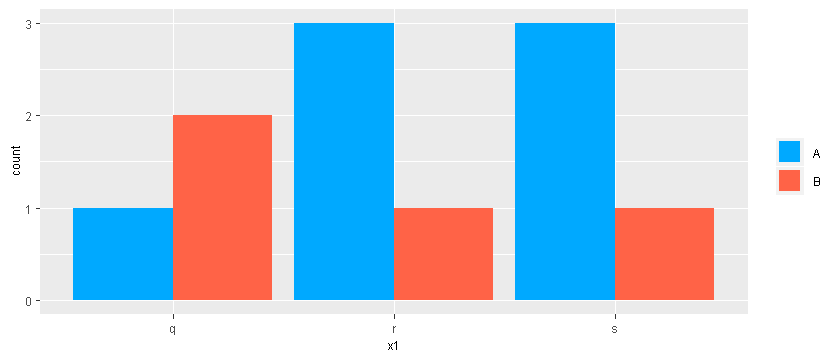

In [14]:
data = data.frame(x1=c("q","r","r","r","s","s","s","r","q","q","s"),
                  class=c("A", "B", "A", "A", "A", "A", "A", "A", "B", "B", "B"))
data %>% caption

ggplot(data) + geom_bar(aes(x=x1, fill=class), position=position_dodge())

#### New Observation

Consider a new unclassified observation [ x1=q ].

In [15]:
new = data.frame(x1="q")
new %>% caption

x1
q


#### Calculate Likelihoods

Here we find the likelihoods of the observations in class A, and the likelihoods of the observations in class B.

In [16]:
data.A = data[data$class=="A",]
data.B = data[data$class=="B",]

row.arrange(data.A %>% captionx, data.B %>% captionx)

x1,class
q,A
r,A
r,A
s,A
s,A
s,A
r,A
x1,class
r,B
q,B


Rather than a probability density function for numeric values, we use a relative frequency table for categorical values.

In [17]:
info.A = data.frame(table(data.A$x1)/nrow(data.A), "A"); colnames(info.A) = c("x1","likelihood","class")
info.B = data.frame(table(data.B$x1)/nrow(data.B), "B"); colnames(info.B) = c("x1","likelihood","class")

row.arrange(info.A %>% captionx, info.B %>% captionx)

x1,likelihood,class
q,0.1428571,A
r,0.4285714,A
s,0.4285714,A
x1,likelihood,class
q,0.50,B
r,0.25,B
s,0.25,B


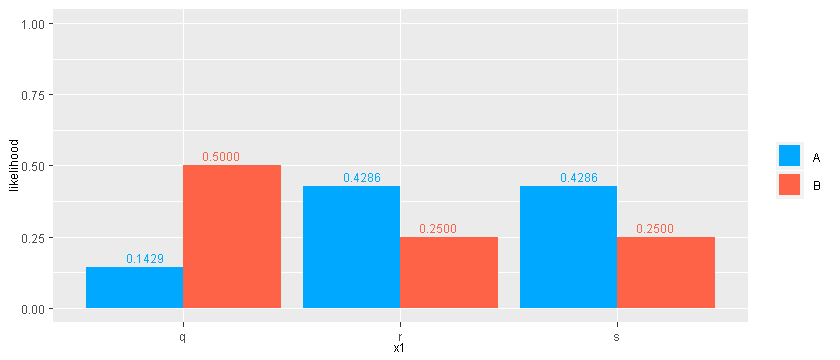

In [18]:
ggplot(rbind(info.A, info.B)) + ylim(0,1) +
geom_col(aes(x=x1, y=likelihood, fill=class), position=position_dodge()) +
geom_text(aes(x=x1, y=likelihood, label=sprintf("%0.4f", likelihood)), data=info.A, color=PALETTE[1], hjust=1.5, vjust=-0.5) +
geom_text(aes(x=x1, y=likelihood, label=sprintf("%0.4f", likelihood)), data=info.B, color=PALETTE[2], hjust=-0.5, vjust=-0.5)

Then, the likelihood of the new observation [ x1=q ] assuming that it's in class A is 0.142, and the likelihood of the new observation [ x1=q ] assuming that it's in class B is 0.500.

In [19]:
rbind(info.A[1,], info.B[1,])

x1,likelihood,class
q,0.1428571,A
q,0.5000000,B


#### Calculate Priors

Here the prior of class A is 0.636 and the prior of class B is 0.363.

In [20]:
row.arrange(data.A %>% captionx, data.B %>% captionx)

x1,class
q,A
r,A
r,A
s,A
s,A
s,A
r,A
x1,class
r,B
q,B


class,prior
A,0.6363636
B,0.3636364


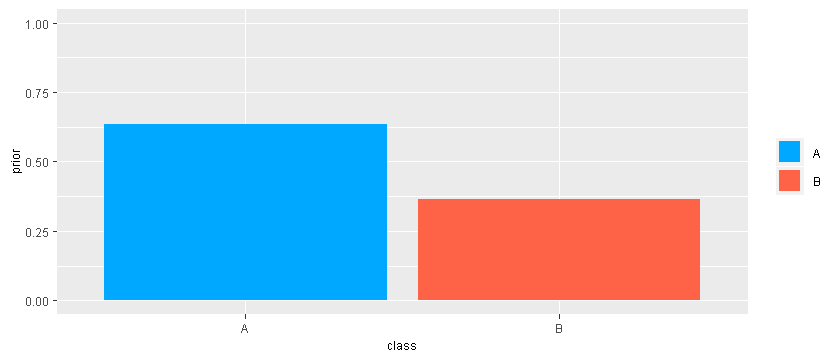

In [21]:
prior.A = nrow(data.A) / nrow(data)
prior.B = nrow(data.B) / nrow(data)

model = data.frame(class=c("A","B"), prior=c(prior.A, prior.B))
model

ggplot(model) + ylim(0,1) + geom_col(aes(x=class, y=prior, fill=class))

#### Predict by Relative Posterior

Here the likelihood of observation [ x1=q ] assuming that it's from class A is 0.143, the prior of class A is 0.636, and so the posterior for observation [ x1=10 ] in class A is 0.143 x 0.636 = 0.091.  Similarly, the posterior for observation [ x1=10 ] in class B is 0.500 x 0.363 = 0.182.

x1,class,likelihood,prior,posterior
q,A,0.1428571,0.6363636,0.09090909
q,B,0.5000000,0.3636364,0.18181818


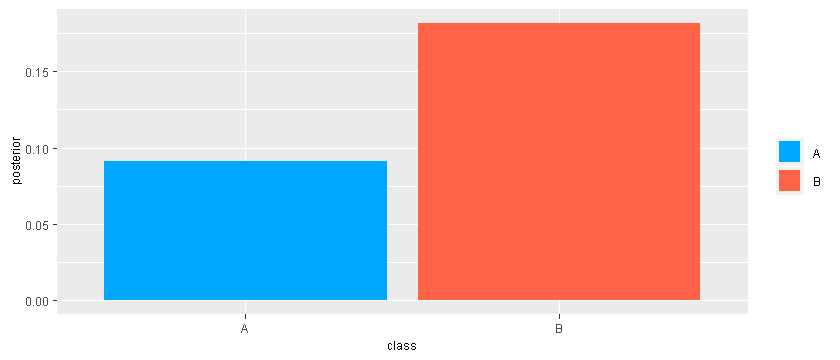

In [22]:
posterior.A = info.A$likelihood[1] * prior.A
posterior.B = info.B$likelihood[1] * prior.B

model.q = data.frame(x1=new$x1,
                     class=c("A","B"),
                     likelihood=c(info.A$likelihood[1], info.B$likelihood[1]),
                     prior=c(prior.A, prior.B),
                     posterior=c(posterior.A, posterior.B))

model.q
ggplot(model.q) + geom_col(aes(x=class, y=posterior, fill=class))

The relative posterior for observation [ x1=10 ] in class A is 0.091 / (0.091+0.182) = 0.333, and the relative posterior for observation [ x1=10 ] in class B is 0.182 / (0.091+0.182) = 0.667.  We treat each relative posterior as the probability that the observation is in a class.

x1,class,likelihood,prior,posterior,relative_posterior,probability
q,A,0.1428571,0.6363636,0.09090909,0.3333333,0.3333333
q,B,0.5000000,0.3636364,0.18181818,0.6666667,0.6666667


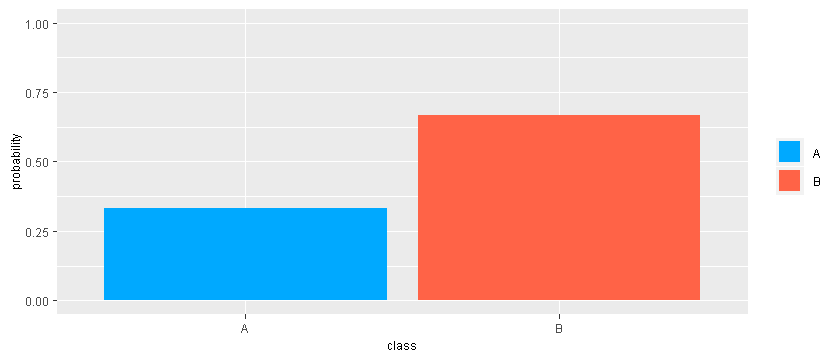

In [23]:
model.q = data.frame(x1=new$x1,
                     class=c("A","B"),
                     likelihood=c(info.A$likelihood[1], info.B$likelihood[1]),
                     prior=c(prior.A, prior.B),
                     posterior=c(posterior.A, posterior.B),
                     relative_posterior=c(posterior.A/(posterior.A+posterior.B), posterior.B/(posterior.A+posterior.B)),
                     probability=c(posterior.A/(posterior.A+posterior.B), posterior.B/(posterior.A+posterior.B)))

model.q
ggplot(model.q) + ylim(0,1) + geom_col(aes(x=class, y=probability, fill=class))

Assuming a cutoff of 0.5, since 0.667 > 0.5, we predict that the observation [ x1=10 ] is of class B.

In [24]:
cutoff = 0.5
prediction = model.q$class[model.q$probability >= cutoff]
data.frame(x1=10, cutoff, class.predicted=prediction)

x1,cutoff,class.predicted
10,0.5,B


### Naive Bayes & Many Predictor Variables

#### Data

Consider this classified data. Each observation is known to be in either class A or class B. 

x1,x2,class
1.0,1.0,A
8.0,2.0,A
8.5,3.5,A
9.5,3.0,A
11.0,5.5,A
9.0,5.0,B
14.0,6.5,B
15.0,7.0,B
16.0,6.2,B
16.5,5.7,B


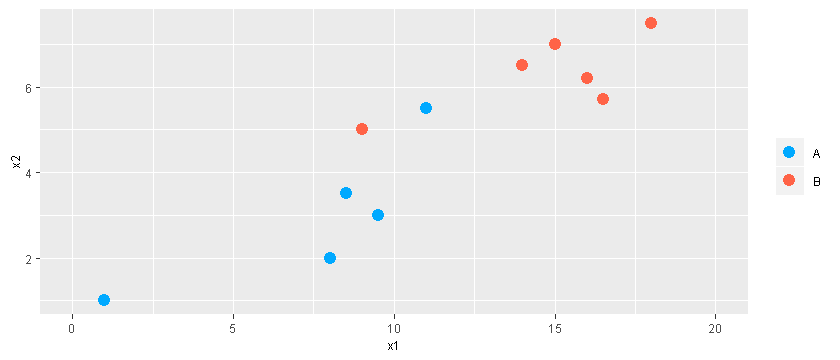

In [25]:
data = data.frame(x1=c(1,8,8.5,9.5,11,9,14,15,16,16.5,18),
                  x2=c(1,2,3.5,3,5.5,5,6.5,7,6.2,5.7,7.5),
                  class=c("A", "A", "A", "A", "A", "B", "B", "B", "B", "B", "B"))

data %>% caption

ggplot(data) + xlim(0,20) + geom_point(aes(x=x1, y=x2, color=class))

#### New Observation

Consider a new unclassified observation [ x1=10, x2=4 ].

x1,x2
10,4


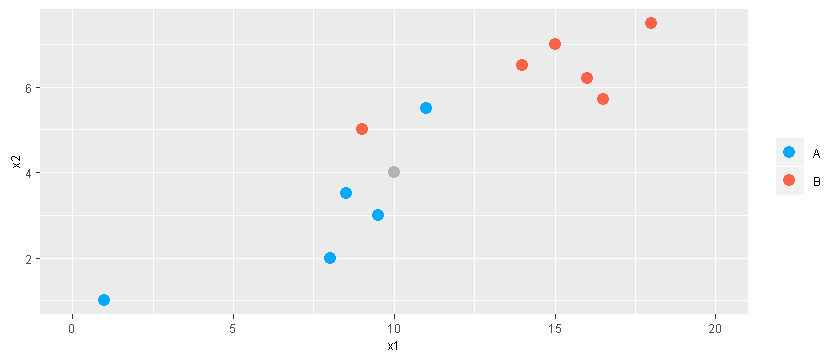

In [26]:
new = data.frame(x1=10, x2=4)
new %>% caption

ggplot(data) + xlim(0,20) +
geom_point(aes(x=x1, y=x2, color=class)) + geom_point(aes(x=10, y=4), color="grey70")

#### Calculate Likelihoods

Here the likelihood of a new observation [x1=10, ... ] assuming that it's in class A is 0.143, and the likelihood of a new observation [ x1=10, ... ] assuming that it's in class B is 0.034.  The likelihood of a new observation [ ..., x2=4 ] assuming that it's in class A is 0.143, and the likelihood of a new observation [ ..., x2=4 ] assuming that it's in class B is 0.040.  Note that we find four probability density functions to find four likelihoods: one for [ x1=10, ... ] and class A, one for [ x1=10, ... ] and class B, one for [ ..., x2=4 ] and class A, and one for [ ..., x2=4 ] and class B.

In [27]:
data.A = data[data$class=="A",]
data.B = data[data$class=="B",]

d.A.x1 = density(data.A[,"x1"], bw=0.7, from=0, to=20); pdf.A.x1 = approxfun(d.A.x1)
d.B.x1 = density(data.B[,"x1"], bw=0.7, from=0, to=20); pdf.B.x1 = approxfun(d.B.x1)

d.A.x2 = density(data.A[,"x2"], bw=0.7, from=0, to=20); pdf.A.x2 = approxfun(d.A.x2)
d.B.x2 = density(data.B[,"x2"], bw=0.7, from=0, to=20); pdf.B.x2 = approxfun(d.B.x2)

x1,class,likelihood
10,A,0.14306430
10,B,0.03435121


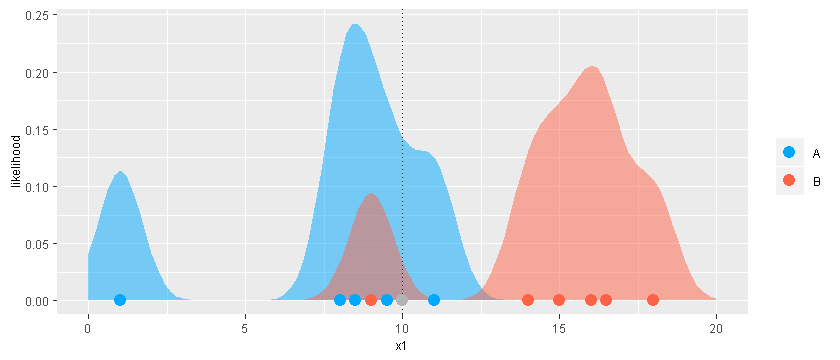

In [28]:
model.x1 = data.frame(x1=10, class=c("A","B"), likelihood=c(pdf.A.x1(10), pdf.B.x1(10)))
model.x1

ggplot(data) + xlim(0,20) + xlab("x1") + ylab("likelihood") +
stat_function(fun=pdf.A.x1, geom="area", fill=PALETTE[1], alpha=0.5) +
stat_function(fun=pdf.B.x1, geom="area", fill=PALETTE[2], alpha=0.5) +
geom_vline(aes(xintercept=10), lty="dotted") +
geom_point(aes(x=10, y=0), color="grey70") +
geom_point(aes(x=x1, y=0, color=class))

x2,class,likelihood
4,A,0.14308327
4,B,0.04026897


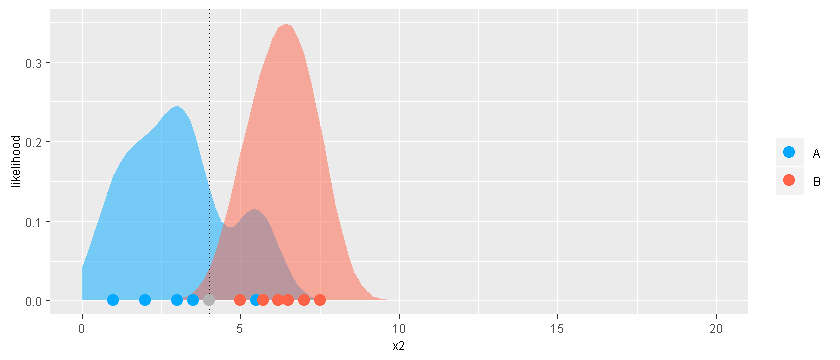

In [29]:
model.x2 = data.frame(x2=4, class=c("A","B"), likelihood=c(pdf.A.x2(4), pdf.B.x2(4)))
model.x2

ggplot(data) + xlim(0,20) + xlab("x2") + ylab("likelihood") +
stat_function(fun=pdf.A.x2, geom="area", fill=PALETTE[1], alpha=0.5) +
stat_function(fun=pdf.B.x2, geom="area", fill=PALETTE[2], alpha=0.5) +
geom_vline(aes(xintercept=4), lty="dotted") +
geom_point(aes(x=4, y=0), color="grey70") +
geom_point(aes(x=x2, y=0, color=class))

#### Calculate Priors

Here the prior of class A is 0.454 and the prior of class B is 0.545.

class,prior
A,0.4545455
B,0.5454545


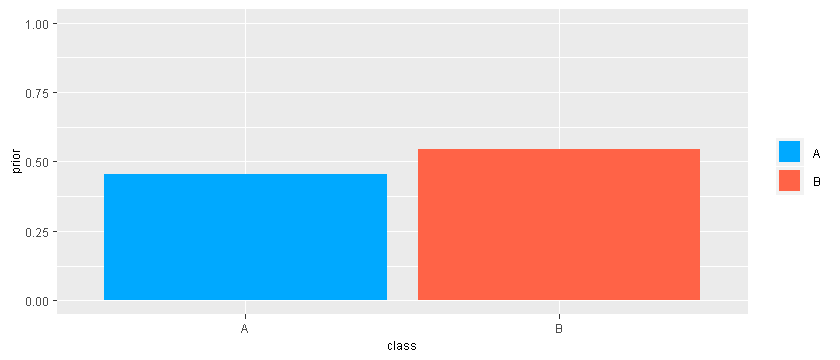

In [30]:
prior.A = nrow(data.A) / nrow(data)
prior.B = nrow(data.B) / nrow(data)

prob = data.frame(class=c("A","B"), prior=c(prior.A, prior.B))
prob

ggplot(prob) + ylim(0,1) + geom_col(aes(x=class, y=prior, fill=class))

#### Predict by Relative Posterior

For a new unclassified observation, the **product** of the likelihoods times the prior of a class is a reasonable basis for predicting the class of the new observation.

Here the likelihood of observation [ x1=10, ... ] assuming that it's from class A is 0.143, the likelihood of observation [ ..., x2=4 ] assuming that it's from class A is 0.143, the prior of class A is 0.454, and so the overall posterior of observation [ x1=10, x2=4 ] in class A is 0.143 x 0.143 x 0.454 = 0.00930.  Similarly, the overall posterior of observation [ x1=10, x2=4 ] in class B is 0.034 x 0.040 x 0.545 = 0.00075.

x1,x2,class,likelihood_x1,likelihood_x2,prior,posterior
10,4,A,0.14306430,0.14308327,0.4545455,0.0093045944
10,4,B,0.03435121,0.04026897,0.5454545,0.0007545206


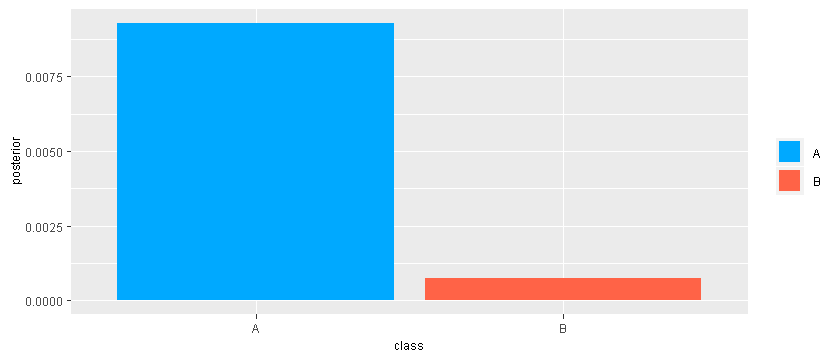

In [31]:
posterior.A = pdf.A.x1(10) * pdf.A.x2(4) * prior.A
posterior.B = pdf.B.x1(10) * pdf.B.x2(4) * prior.B

model.10.4 = data.frame(x1=10,
                        x2=4,
                        class=c("A","B"),
                        likelihood_x1=c(pdf.A.x1(10), pdf.B.x1(10)),
                        likelihood_x2=c(pdf.A.x2(4), pdf.B.x2(4)),
                        prior=c(prior.A, prior.B),
                        posterior=c(posterior.A, posterior.B))


model.10.4
ggplot(model.10.4) + geom_col(aes(x=class, y=posterior, fill=class))

The relative posteriors are then 0.0093 / (0.00930+0.00075) = 0.924 for class A and 0.00075 / (0.00930+0.00075) = 0.075 for class B.

class,likelihood_x1,likelihood_x2,prior,posterior,relative_posterior,probability
A,0.14306430,0.14308327,0.4545455,0.0093045944,0.92499135,0.92499135
B,0.03435121,0.04026897,0.5454545,0.0007545206,0.07500865,0.07500865


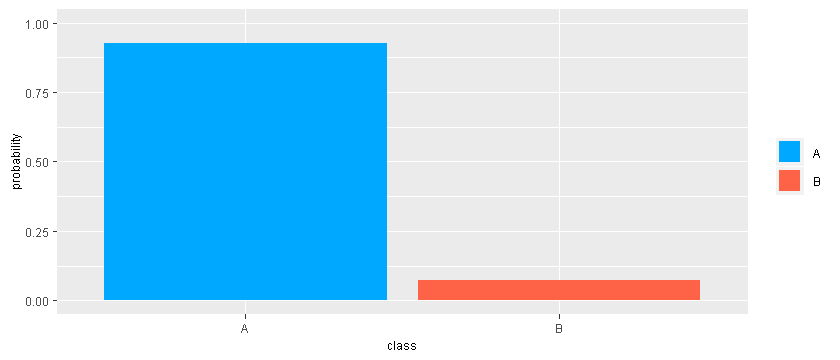

In [32]:
model.10.4 = data.frame(class=c("A","B"),
                        likelihood_x1=c(pdf.A.x1(10), pdf.B.x1(10)),
                        likelihood_x2=c(pdf.A.x2(4), pdf.B.x2(4)),
                        prior=c(prior.A, prior.B),
                        posterior=c(posterior.A, posterior.B),
                        relative_posterior=c(posterior.A/(posterior.A+posterior.B), posterior.B/(posterior.A+posterior.B)),
                        probability=c(posterior.A/(posterior.A+posterior.B), posterior.B/(posterior.A+posterior.B)))


model.10.4
ggplot(model.10.4) + ylim(0,1) + geom_col(aes(x=class, y=probability, fill=class))

Assuming a cutoff of 0.5, since 0.924 > 0.5, we predict that the observation [ x1=10, x2=4 ] is of class A.

In [33]:
cutoff = 0.5
prediction = model.10.4$class[model.10.4$probability >= cutoff]
data.frame(x1=10, x2=4, cutoff, class.predicted=prediction)

x1,x2,cutoff,class.predicted
10,4,0.5,A


### Naive Bayes with Gaussian Estimation

#### Data

Consider this classified data. Each observation is known to be in either class A or class B. 

x1,class
1.0,A
8.0,A
8.5,A
9.5,A
11.0,A
9.0,B
14.0,B
15.0,B
16.0,B
16.5,B


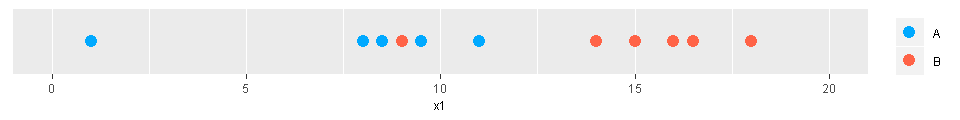

In [34]:
data = data.frame(x1=c(1,8,8.5,9.5,11,9,14,15,16,16.5,18),
                  class=c("A", "A", "A", "A", "A", "B", "B", "B", "B", "B", "B"))
data %>% caption 

output_size(8,1)
ggplot(data) + xlim(0,20) + geom_point(aes(x=x1, y=0, color=class)) + theme.x_axis_only
output_size(restore)

#### New Observation

Consider a new unclassified observation [ x1=q ].

x1
10


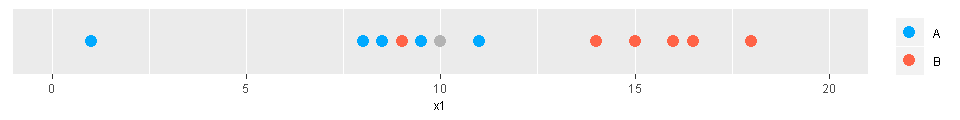

In [35]:
new = data.frame(x1=10)
new %>% caption

output_size(8,1)
ggplot(data) + xlim(0,20) + geom_point(aes(x=x1, y=0, color=class)) +
geom_point(aes(x=new$x1, y=0), color="grey70") + theme.x_axis_only
output_size(restore)

#### Calculate Likelihoods

Use Gaussian estimation, rather than kernel density estimation, to find probability density functions.  Gaussian estimation takes the mean and standard deviation of the observations as its parameters.

class,mean,sd
A,7.60,3.863289
B,14.75,3.126500


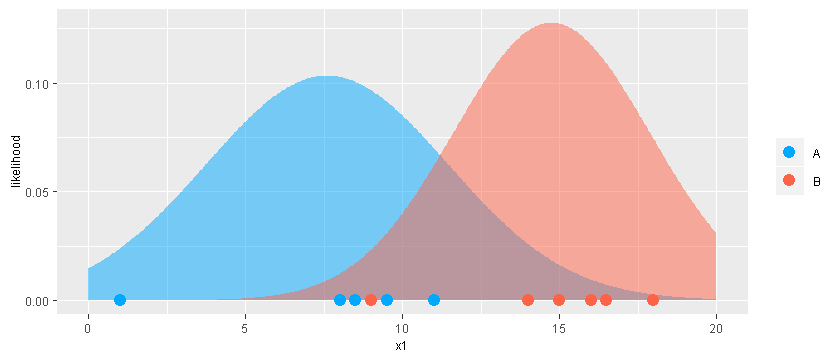

In [36]:
data.A = data[data$class=="A",]
data.B = data[data$class=="B",]

mean.A = mean(data.A$x1); sd.A = sd(data.A$x1)
mean.B = mean(data.B$x1); sd.B = sd(data.B$x1)

parms = data.frame(class=c("A","B"), mean=c(mean.A, mean.B), sd=c(sd.A,sd.B))
parms

ggplot(data) + xlim(0,20) + ylab("likelihood") +
stat_function(fun=gaussian, args=c(mean=mean.A, sd=sd.A), n=500, geom="area", fill=PALETTE[1], alpha=0.5) +
stat_function(fun=gaussian, args=c(mean=mean.B, sd=sd.B), n=500, geom="area", fill=PALETTE[2], alpha=0.5) +
geom_point(aes(x=x1, y=0, color=class))

Here the likelihood of observation [ x1=10 ] in class A is 0.085, and the likelihood of observation [ x1=10 ] in class B is 0.040.

x1,class,likelihood
10,A,0.08514308
10,B,0.04023795


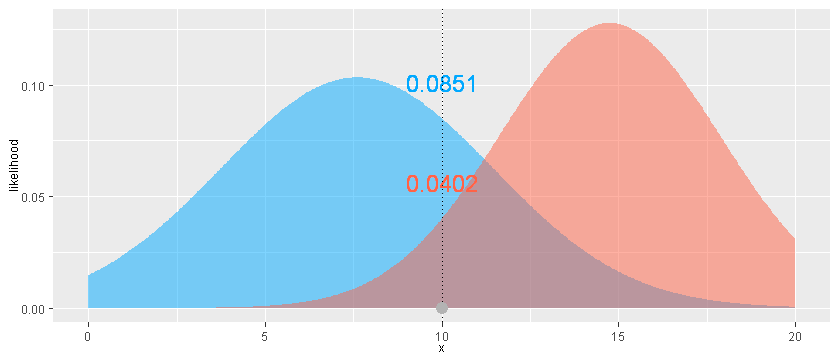

In [37]:
model = data.frame(x1=10, class=c("A","B"), likelihood=c(gaussian(10, mean.A, sd.A), gaussian(10, mean.B, sd.B)))
model

ggplot(data) + xlim(0,20) + ylab("likelihood") +
stat_function(fun=gaussian, args=c(mean=mean.A, sd=sd.A), n=500, geom="area", fill=PALETTE[1], alpha=0.5) +
stat_function(fun=gaussian, args=c(mean=mean.B, sd=sd.B), n=500, geom="area", fill=PALETTE[2], alpha=0.5) +
geom_text(aes(x=10, y=model[1,"likelihood"]), color=PALETTE[1], size=5, label=sprintf("%0.4f",model[1,"likelihood"])) +
geom_text(aes(x=10, y=model[2,"likelihood"]), color=PALETTE[2], size=5, label=sprintf("%0.4f",model[2,"likelihood"])) +
geom_vline(aes(xintercept=new$x1), lty="dotted") +
geom_point(aes(x=new$x1, y=0), color="grey70")

### Naive Bayes with Laplace Smoothing

#### Data

Consider this classified data. Each observation is known to be in either class A or class B. 

x1,x2,class
q,w,A
r,u,B
r,v,A
r,v,A
s,v,A
s,v,A
s,u,A
r,u,A
q,u,B
q,v,B


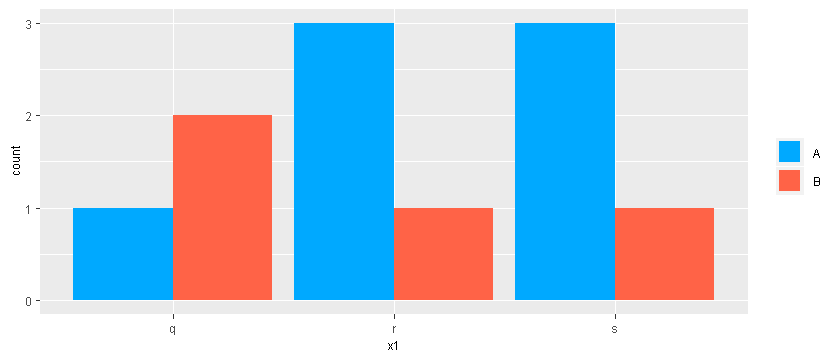

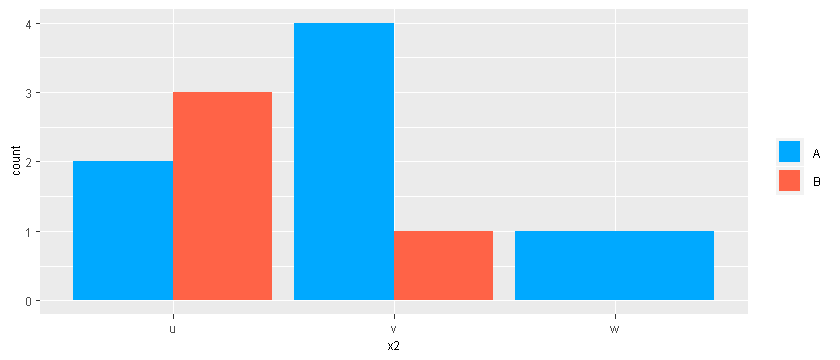

In [38]:
data = data.frame(x1=c("q","r","r","r","s","s","s","r","q","q","s"), 
                  x2=c("w","u","v","v","v","v","u","u","u","v","u"),
                  class=c("A", "B", "A", "A", "A", "A", "A", "A", "B", "B", "B"))
data %>% caption

ggplot(data) + geom_bar(aes(x=x1, fill=class), position=position_dodge())
ggplot(data) + geom_bar(aes(x=x2, fill=class), position=position_dodge())

#### New Observation

Consider a new unclassified observation [ x1=q, x2=w ].

In [39]:
new = data.frame(x1="q", x2="w")
new %>% caption

x1,x2
q,w


#### Calculate LIkelihoods

Examine each class separately ...

In [40]:
data.A = data[data$class=="A",]
data.B = data[data$class=="B",]

row.arrange(data.A %>% captionx, data.B %>% captionx)

x1,x2,class
q,w,A
r,v,A
r,v,A
s,v,A
s,v,A
s,u,A
r,u,A
x1,x2,class
r,u,B
q,u,B


Likelihoods derived from relative frequency tables ...

In [41]:
info.A.x1 = data.frame(table(data.A$x1)); colnames(info.A.x1)=c("x1","count"); info.A.x1$likelihood = info.A.x1$count/nrow(data.A); info.A.x1$class="A" 
info.B.x1 = data.frame(table(data.B$x1)); colnames(info.B.x1)=c("x1","count"); info.B.x1$likelihood = info.B.x1$count/nrow(data.B); info.B.x1$class="B" 

info.A.x2 = data.frame(table(data.A$x2)); colnames(info.A.x2)=c("x2","count"); info.A.x2$likelihood = info.A.x2$count/nrow(data.A); info.A.x2$class="A" 
info.B.x2 = data.frame(table(data.B$x2)); colnames(info.B.x2)=c("x2","count"); info.B.x2$likelihood = info.B.x2$count/nrow(data.B); info.B.x2$class="B" 

row.arrange(info.A.x1 %>% captionx, info.B.x1 %>% captionx)
row.arrange(info.A.x2 %>% captionx, info.B.x2 %>% captionx)

x1,count,likelihood,class
q,1,0.1428571,A
r,3,0.4285714,A
s,3,0.4285714,A
x1,count,likelihood,class
q,2,0.50,B
r,1,0.25,B
s,1,0.25,B


x2,count,likelihood,class
u,2,0.2857143,A
v,4,0.5714286,A
w,1,0.1428571,A
x2,count,likelihood,class
u,3,0.75,B
v,1,0.25,B
w,0,0.00,B


Here are the likelihoods for the new observation [ x1=q, x2=w ].

In [42]:
row.arrange(rbind(info.A.x1[1,-2], info.B.x1[1,-2]) %>% captionx("info.x1"),
            rbind(info.A.x2[3,-2], info.B.x2[3,-2]) %>% captionx("info.x2"))

x1,likelihood,class
q,0.1428571,A
q,0.5000000,B
x2,likelihood,class
w,0.1428571,A
w,0.0000000,B


#### Calculate LIkelihoods adjusted by Laplace Smoothing

Note that the likelihood of an observation [ ..., x2=w ] is zero, and so the relative posterior of any observation that includes x2=w will be zero.  This may not be desirable, since it causes the prediction for that observation to ignore the influence of any other variables.

To adjust for this, calculate the likelihood for each variable value as though there were one extra occurrence of that value.

Here a frequency table of x1 values among observations in class A shows that there is 1 occcurrence of q, 3 occurrences of r, and 3 occurrences of s.  For calculation purposes, we add one to each to get 2 occurrences of q, 4 occurrences of r, and 4 occurrences of s.  Similarly for the other frequency tables.

In [43]:
row.arrange(info.A.x1[,-3] %>% fmt %>% captionx("info.A.x1"),
            info.B.x1[,-3] %>% fmt %>% captionx("info.B.x1"),
            info.A.x2[,-3] %>% fmt %>% captionx("info.A.x2"),
            info.B.x2[,-3] %>% fmt %>% captionx("info.B.x2"))

x1,count,class
q,1,A
r,3,A
s,3,A
x1,count,class
q,2,B
r,1,B
s,1,B
x2,count,class
u,2,A
v,4,A


In [44]:
info.A.x1$count.s = info.A.x1$count+1
info.B.x1$count.s = info.B.x1$count+1
info.A.x2$count.s = info.A.x2$count+1
info.B.x2$count.s = info.B.x2$count+1

row.arrange(info.A.x1[,c(1,5,4)] %>% captionx("info.A.x1 smoothed"),
            info.B.x1[,c(1,5,4)] %>% captionx("info.B.x1 smoothed"),
            info.A.x2[,c(1,5,4)] %>% captionx("info.A.x2 smoothed"),
            info.B.x2[,c(1,5,4)] %>% captionx("info.B.x2 smoothed"))

x1,count.s,class
q,2,A
r,4,A
s,4,A
x1,count.s,class
q,3,B
r,2,B
s,2,B
x2,count.s,class
u,3,A
v,5,A


From the adjusted frequency tables, calculate laplace-adjusted likelihoods.  Note that all laplace-adjusted likelihoods are non-zero, so subsequent relative posteriors can never fully ignore the influence of all variables.

In [45]:
info.A.x1$likelihood.s = info.A.x1$count.s/sum(info.A.x1$count.s)
info.B.x1$likelihood.s = info.B.x1$count.s/sum(info.B.x1$count.s)
info.A.x2$likelihood.s = info.A.x2$count.s/sum(info.A.x2$count.s)
info.B.x2$likelihood.s = info.B.x2$count.s/sum(info.B.x2$count.s)

row.arrange(info.A.x1[,c(1,5,6,4)] %>% captionx("info.A.x1 smoothed"),
            info.B.x1[,c(1,5,6,4)] %>% captionx("info.B.x1 smoothed"))
row.arrange(info.A.x2[,c(1,5,6,4)] %>% captionx("info.A.x2 smoothed"),
            info.B.x2[,c(1,5,6,4)] %>% captionx("info.B.x2 smoothed"))

x1,count.s,likelihood.s,class
q,2,0.2,A
r,4,0.4,A
s,4,0.4,A
x1,count.s,likelihood.s,class
q,3,0.4285714,B
r,2,0.2857143,B
s,2,0.2857143,B


x2,count.s,likelihood.s,class
u,3,0.3,A
v,5,0.5,A
w,2,0.2,A
x2,count.s,likelihood.s,class
u,4,0.5714286,B
v,2,0.2857143,B
w,1,0.1428571,B


Here are the laplace-adjusted likelihoods for the new observation [ x1=q, x2=w ].

In [46]:
row.arrange(rbind(info.A.x1[1,c(1,6,4)], info.B.x1[1,c(1,6,4)]) %>% captionx("info.x1"),
            rbind(info.A.x2[3,c(1,6,4)], info.B.x2[3,c(1,6,4)]) %>% captionx("info.x2"))

x1,likelihood.s,class
q,0.2000000,A
q,0.4285714,B
x2,likelihood.s,class
w,0.2000000,A
w,0.1428571,B


### Statistical Basis for Naive Bayes Method

<br/>
Bayes Rule:
$$
P(class=A\,|\,x1=u,\,x2=v,...) = \frac{ P(x1=u,\,x2=v, ...|\,class=A) \,\times\, P(class=A) }{ P(x1=u,\,x2=v,...) }
$$

$$
P(class=B\,|\,x1=u,\,x2=v,...) = \frac{ P(x1=u,\,x2=v,...|\,class=B) \,\times\, P(class=B) }{ P(x1=u,\,x2=v,...) }
$$


<br/><br/>
Treat x1, x2, ... as mutually independent - this is the "naive" assumption.  Calculate the posteriors:

$$
P(class=A\,|\,x1=u,\,x2=v,...) = \frac{ P(x1=u\,|\,class=A) \,\times\, P(x2=v\,|\,class=A) \,\times\, ... \,\times\, P(class=A) }{ P(x1=u,\,x2=v,...) }
$$

$$
P(class=B\,|\,x1=u,\,x2=v,...) = \frac{ P(x1=u\,|\,class=B) \,\times\, P(x2=v\,|\,class=B) \,\times\, ... \,\times\, P(class=B) }{ P(x1=u,\,x2=v,...) }
$$

<br/><br/>
Ignore the denominators because they are equivalent and do not affect the relative sizes of the posteriors:

$$
P(class=A\,|\,x1=u,\,x2=v,...) \approx P(x1=u\,|\,class=A) \,\times\, P(x2=v\,|\,class=A) \,\times\, ... \,\times\, P(class=A)
$$

$$
P(class=B\,|\,x1=u,\,x2=v,...) \approx P(x1=u\,|\,class=B) \,\times\, P(x2=v\,|\,class=B) \,\times\, ... \,\times\, P(class=B)
$$

<br/><br/>
Calculate the relative posteriors:


$$
relative\,posterior_A = \frac{P(x1=u\,|\,class=A) \,\times\, P(x2=v\,|\,class=A) \,\times\, ... \,\times\, P(class=A)}
{\begin{align}
& \big[ P(x1=u\,|\,class=A) \,\times\, P(x2=v\,|\,class=A) \,\times\, ... \,\times\, P(class=A) \big] + \\
    & \big[ P(x1=u\,|\,class=B) \,\times\, P(x2=v\,|\,class=B) \,\times\, ... \,\times\, P(class=B) \big]
\end{align}}
$$

<br/>

$$
relative\,posterior_B = \frac{P(x1=u\,|\,class=B) \,\times\, P(x2=v\,|\,class=B) \,\times\, ... \,\times\, P(class=B)}
{\begin{align}
& \big[ P(x1=u\,|\,class=A) \,\times\, P(x2=v\,|\,class=A) \,\times\, ... \,\times\, P(class=A) \big] + \\
    & \big[ P(x1=u\,|\,class=B) \,\times\, P(x2=v\,|\,class=B) \,\times\, ... \,\times\, P(class=B) \big]
\end{align}}
$$


<br/><br/>
The relative posteriors expressed in succint notation:


$$
P(c|X) \approx \frac{\big( \prod_{x \in X} P(x|c) \big) P(c)}{\sum_{c \in C} \big( \big( \prod_{x \in X} P(x|c) \big) P(c) \big)}
$$


<br/><br/>
Predict the class that corresponds to the relative posterior that exceeds some cutoff.

## Code

### Useful Functions

In [47]:
# as.class # from appartus code cell above

# help(naiveBayes)         # from e1071 library
# help(predict)            # from stats library
# help(predict.naiveBayes) # from e1071 library, use predict to call this function  

### Templates

In [48]:
# Construct a naive Bayes model 

data.train = data.frame(x1=c(1,2,3,4,5,6,7,8), x2=c(9,7,6,5,4,3,2,1), x3=c("E","C","D","E","C","D","E","E"),
                        class=c("B", "B", "B", "B", "A", "B", "A", "B"))

model = naiveBayes(class ~ x1+x2+x3, data.train)
model


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
   A    B 
0.25 0.75 

Conditional probabilities:
   x1
Y   [,1]     [,2]
  A    6 1.414214
  B    4 2.607681

   x2
Y       [,1]     [,2]
  A 3.000000 1.414214
  B 5.166667 2.857738

   x3
Y           C         D         E
  A 0.5000000 0.0000000 0.5000000
  B 0.1666667 0.3333333 0.5000000


In [49]:
# Construct a naive Bayes model with LaPlace smoothing

data.train = data.frame(x1=c(1,2,3,4,5,6,7,8), x2=c(9,7,6,5,4,3,2,1), x3=c("E","C","F","C","D","D","E","F"),
                        class=c("A", "B", "A", "B", "A", "B", "B", "B"))

model = naiveBayes(class ~ x1+x2+x3, data.train, laplace=TRUE)
model


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
    A     B 
0.375 0.625 

Conditional probabilities:
   x1
Y   [,1]     [,2]
  A  3.0 2.000000
  B  5.4 2.408319

   x2
Y       [,1]     [,2]
  A 6.333333 2.516611
  B 3.600000 2.408319

   x3
Y           C         D         E         F
  A 0.1428571 0.2857143 0.2857143 0.2857143
  B 0.3333333 0.2222222 0.2222222 0.2222222


In [50]:
# Use a naive Bayes model to make predictions

new = data.frame(x1=c(5,6,7,8), x2=c(8,7,6,5), x3=c("D","D","F","C"))
cutoff = 0.6

prob = predict(model, new, type="raw")
class.predicted = as.class(prob, "A", cutoff)

prob %>% caption
class.predicted %>% fmt
cbind(new, class.predicted)

A,B
0.6996741,0.3003259
0.4377705,0.5622295
0.1963533,0.8036467
0.0234317,0.9765683


class.predicted
A
B
B
B


x1,x2,x3,class.predicted
5,8,D,A
6,7,D,B
7,6,F,B
8,5,C,B


## Expectations

Know about this:
* How to build a naive bayes model based on classified data, and use it to predict the classes of new observations, conceptually and using R's `naiveBayes` and `predict` functions.

## Further Reading

* http://www.cs.columbia.edu/~mcollins/em.pdf
* http://ciml.info/dl/v0_99/ciml-v0_99-ch09.pdf
* https://en.wikipedia.org/wiki/Naive_Bayes_classifier
* https://en.wikipedia.org/wiki/Bayes%27_theorem
* https://www.quora.com/How-does-Laplacian-add-1-smoothing-work-for-a-Naive-Bayes-classfier-algorithm
* https://norvig.com/spell-correct.html

<p style="text-align:left; font-size:10px;">
Copyright (c) Berkeley Data Analytics Group, LLC
<span style="float:right;">
Document revised Sep 10, 2019
</span>
</p>